In [1]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to compute the hessian during training for fitting a simple 1D ODE using a normal neural network.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [2]:
%%capture
%%bash 
pip install torchdiffeq

In [3]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--manual_hessian', action='store_true')
parser.add_argument('--library_hessian', action='store_true')
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.batch_size = 10
args.batch_time = 20
args.niters=5000
args.test_freq=100
args.library_hessian = True
args.manual_hessian = False
args.viz = True
args.hessian_freq = 100
args.method = 'dopri5'

In [5]:
#The technique only works when the adjoint method is not used. If it is used, the Hessian returned is a matrix of zeros.
adjoint = False

if adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
if adjoint == False:
    from torchdiffeq import odeint

In [6]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [7]:
args.data_size = 1000

true_y0 = torch.tensor([2.]).to(device)
t_0, t_1 = 0., 2.
t = torch.linspace(t_0, t_1, args.data_size).to(device)

In [8]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.exp(t)

In [9]:
#The true solution defines an exponential.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method = args.method)

In [10]:
def get_batch():

    #List of 20 random integers.
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False)) 

    #List of 20 random points in the actual solution.
    batch_y0 = true_y[s]  # (M, D)  

    #The first (10) values from t.
    batch_t = t[:args.batch_time]  # (T)     
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)    Set of 20 lots of 10 sequential points in true_y.
    t_list = torch.stack([t[s + i] for i in range(args.batch_time)], dim=0)

    return batch_y0.to(device), batch_t.to(device), batch_y.to(device), t_list.to(device)

In [11]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [12]:
%%capture
if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')    

In [13]:
def visualize(true_y, pred_y, odefunc, itr):

  """
  This slightly altered version of the function visualize() seems to work fine. The only change is that I have moved the plt.figure() part of the code
  inside the function itself, i.e. I am creating a new figure environment for every figure, instead of editing the same environment multiple times.
  """

  if args.viz:

    fig = plt.figure(figsize=(12, 4), facecolor='white')  #facecolor is the background colour.
    plt.plot(t.cpu().numpy(), true_y.cpu().numpy(), 'g-', label='True_y')
    plt.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy(), 'b--', label='Predicted y')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
    #plt.savefig('png/{:03d}'.format(itr))
    plt.draw()
    plt.pause(0.001)
    plt.close()

In [14]:
class Ordinary_Net(nn.Module):

    def __init__(self):
        super(Ordinary_Net, self).__init__()

        #Define a very simple neural network architecture with 1 hidden layer.
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )
        
        for m in self.net.modules():
          if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0, std=0.1)
            nn.init.constant_(m.bias, val=0)

    def forward(self, y):
        return self.net(y)

net = Ordinary_Net()

In [15]:
def get_pred_y(t_array, network):
  """
  Evaluates network(t) for every t in an array of test values.
  """
  if t_array.ndim == 1:
    pred_y = torch.zeros_like(t_array).to(device)
    for i in range(len(t)):
      t_value = t_array[i]
      t_value = torch.reshape(t_value, (1,))
      input = t_value.to(device)
      output = network(input)
      pred_y[i] = output
    pred_y = torch.reshape(pred_y, (args.data_size, 1))

  else:  
    pred_y = torch.zeros_like(t_array).to(device)
    for i in range(t_array.shape[0]):
      for j in range(t_array.shape[1]):
        t_value = t_array[i,j]
        t_value = torch.reshape(t_value, (1,))
        input = t_value.to(device)
        output = network(input)
        pred_y[i,j] = output
    pred_y = torch.reshape(pred_y, (args.batch_time, args.batch_size, 1))
  
  return(pred_y)

In [16]:
class Network(nn.Module):

  def __init__(self, a, b, c, d):
    super(Network, self).__init__()
    self.a = a
    self.b = b
    self.c = c
    self.d = d

  def forward(self, y):
    x = F.linear(y, self.a, self.b)
    m = nn.Tanh()
    x = m(x)
    x = F.linear(x, self.c, self.d)
    return x


def get_loss_square(params_vector):

  a = params_vector[:10].reshape([10, 1])
  b = params_vector[10:20].reshape([10])
  c = params_vector[20:30].reshape([1, 10])
  d = params_vector[30:31].reshape([1])
  
  neural_net = Network(a, b, c, d).to(device)
  pred_y = get_pred_y(t, neural_net).to(device) 
  loss = torch.mean(torch.abs(pred_y - true_y))
  return loss

def get_library_hessian(net):

  param_tensors = net.parameters()
  params_vector = torch.tensor([]).to(device)
  for param in param_tensors:
    vec = torch.reshape(param, (-1,)).to(device)
    params_vector = torch.cat((params_vector, vec))

  hessian = torch.autograd.functional.hessian(get_loss_square, params_vector)
  return hessian

In [17]:
def get_manual_hessian(grads, parameters):
  """
  Calculation of the Hessian using nested for loops.
  Inputs: 
    grads:      tuple of gradient tensors. Created using something like grads = torch.autograd.grad(loss, parameters, create_graph=True).
    parameters: list of parameter objects. Created using something like parameters = optimizer.param_groups[0]['params'].
  """
  start = time.time()                       #Begin timer.

  n_params = 0
  for param in parameters:
    n_params += torch.numel(param)
  grads2 = torch.zeros(n_params,n_params)             #Create an matrix of zeros thas has the same shape as the Hessian.

  y_counter = 0                             #y_direction refers to row number in the Hessian.

  for grad in grads:
      grad = torch.reshape(grad, [-1])                                  #Rearrange the gradient information into a vector.        

      for j, g in enumerate(grad):
        x_counter = 0                                                   #x_direction refers to column number in the Hessian.

        for l, param in enumerate(parameters):
          g2 = torch.autograd.grad(g, param, retain_graph=True)[0]      #Calculate the gradient of an element of the gradient wrt one layer's parameters.
          g2 = torch.reshape(g2, [-1])                                  #Reshape this into a vector.
          len = g2.shape[0]                       
          grads2[j+y_counter, x_counter:x_counter+len] = g2             #Indexing ensures that the second order derivatives are placed in the correct positions.
          x_counter += len

      grads2 = grads2.to(device)
      y_counter += grad.shape[0]
      print("Gradients calculated for row number " + str(y_counter) + ".")
  
  print('Time used was ', time.time() - start)

  return grads2

Obtaining library hessian...
Time taken for library-based approach was 26.34s.
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Obtaining library hessian...
Time taken for library-based approach was 26.38s.
Iter 0100 | Total Loss 2.463753


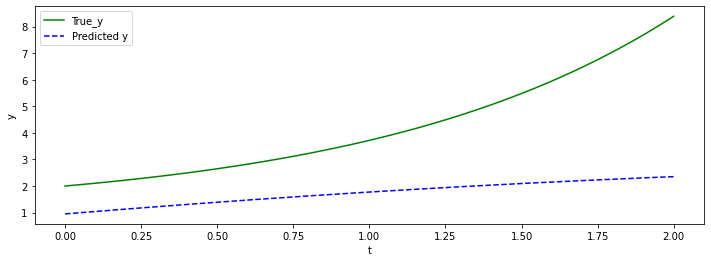

100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,Obtaining library hessian...
Time taken for library-based approach was 26.55s.
Iter 0200 | Total Loss 1.008268


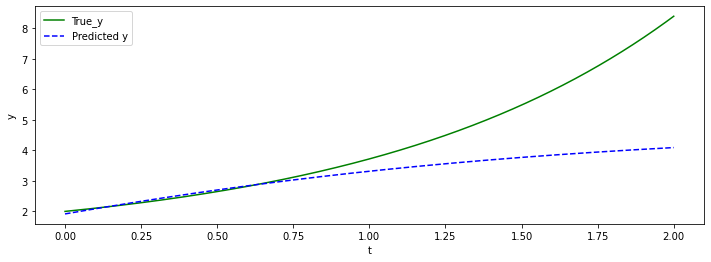

200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Obtaining library hessian...
Time taken for library-based approach was 27.69s.
Iter 0300 | Total Loss 0.827369


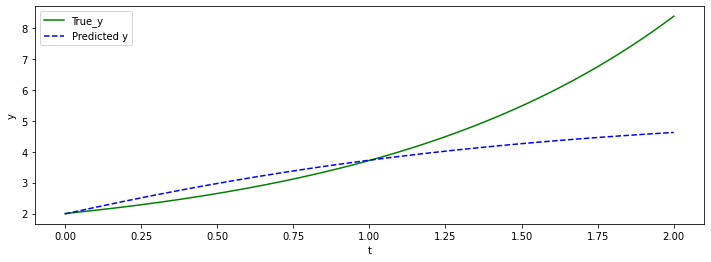

300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,Obtaining library hessian...
Time taken for library-based approach was 25.59s.
Iter 0400 | Total Loss 0.717573


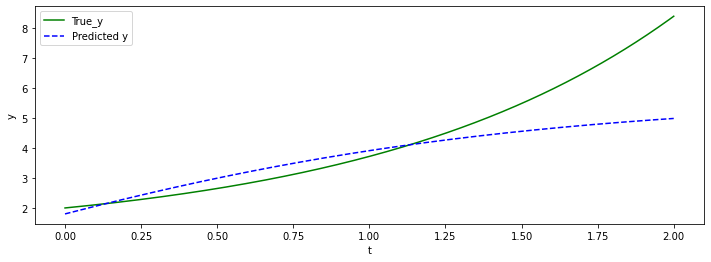

400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Obtaining library hessian...
Time taken for library-based approach was 26.56s.
Iter 0500 | Total Loss 0.635013


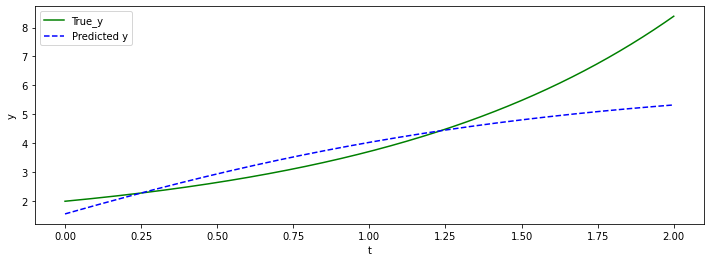

500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,Obtaining library hessian...
Time taken for library-based approach was 27.2s.
Iter 0600 | Total Loss 0.577284


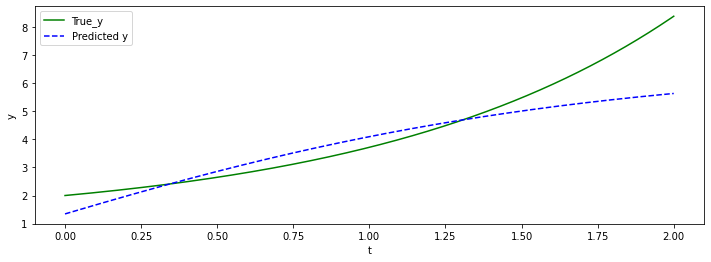

600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,Obtaining library hessian...
Time taken for library-based approach was 27.05s.
Iter 0700 | Total Loss 0.535822


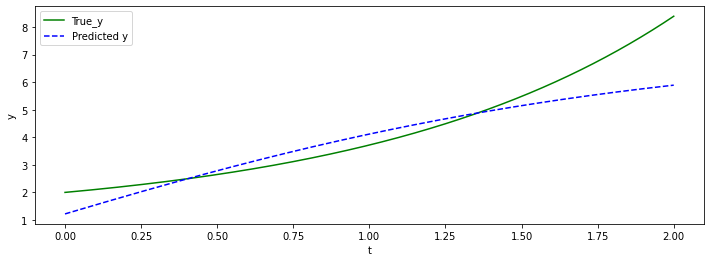

700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,Obtaining library hessian...
Time taken for library-based approach was 26.21s.
Iter 0800 | Total Loss 0.502922


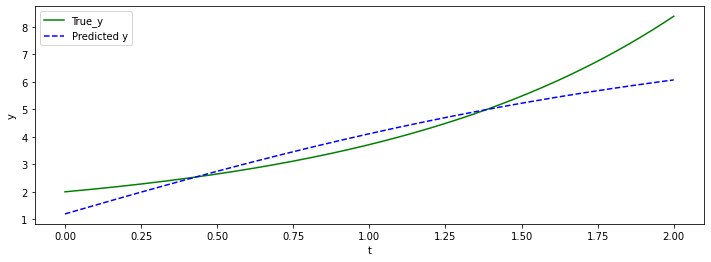

800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,Obtaining library hessian...
Time taken for library-based approach was 26.62s.
Iter 0900 | Total Loss 0.476501


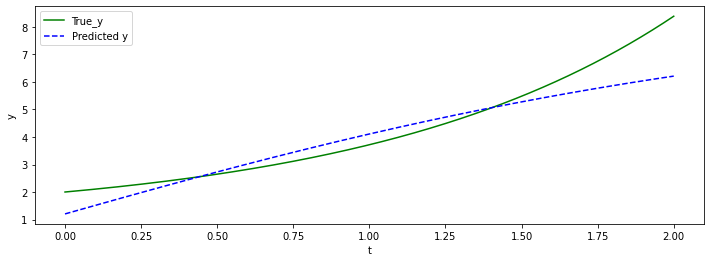

900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,Obtaining library hessian...
Time taken for library-based approach was 26.94s.
Iter 1000 | Total Loss 0.455604


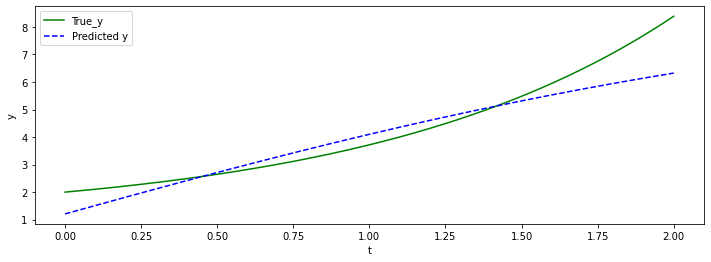

1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,Obtaining library hessian...
Time taken for library-based approach was 26.49s.
Iter 1100 | Total Loss 0.438664


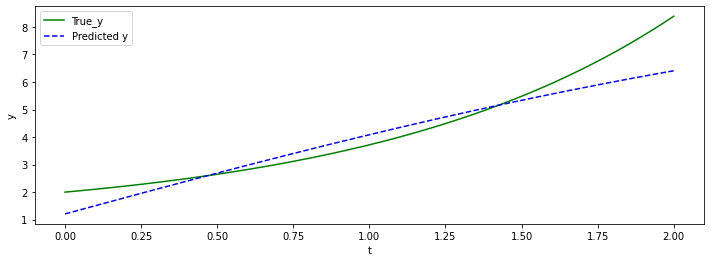

1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,Obtaining library hessian...
Time taken for library-based approach was 28.13s.
Iter 1200 | Total Loss 0.423993


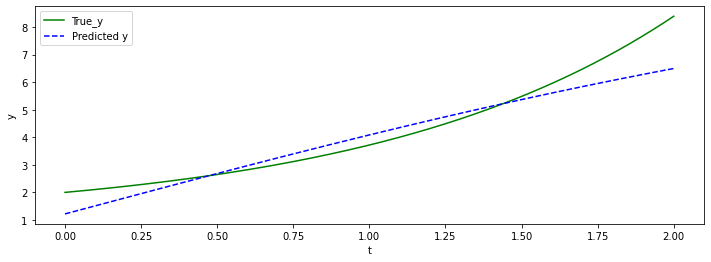

1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,Obtaining library hessian...
Time taken for library-based approach was 27.65s.
Iter 1300 | Total Loss 0.410502


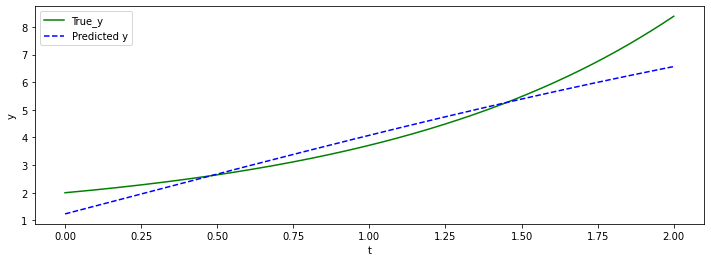

1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,Obtaining library hessian...
Time taken for library-based approach was 26.67s.
Iter 1400 | Total Loss 0.397241


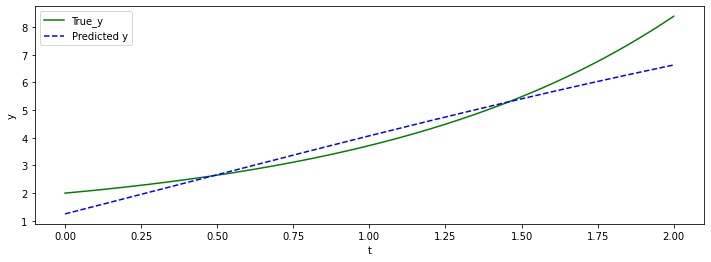

1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,Obtaining library hessian...
Time taken for library-based approach was 26.38s.
Iter 1500 | Total Loss 0.383676


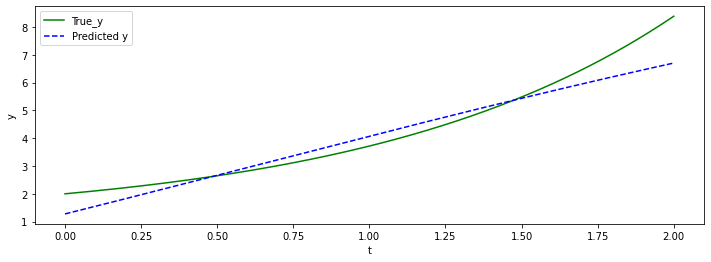

1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,Obtaining library hessian...
Time taken for library-based approach was 25.65s.
Iter 1600 | Total Loss 0.369400


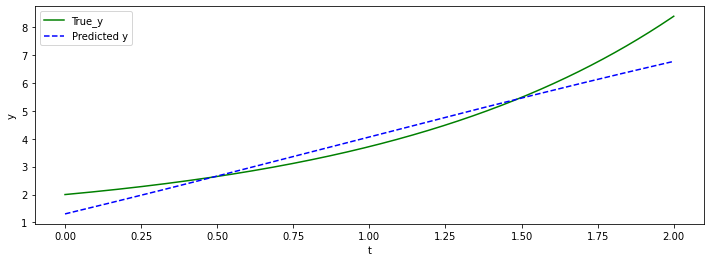

1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,Obtaining library hessian...
Time taken for library-based approach was 24.18s.
Iter 1700 | Total Loss 0.354038


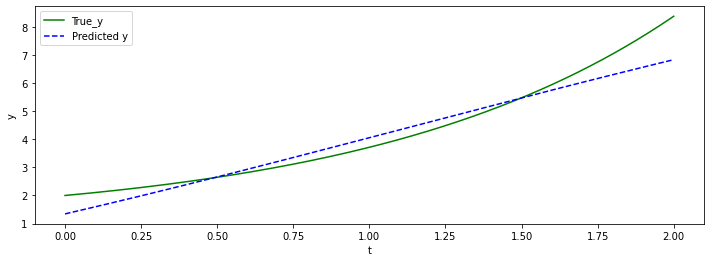

1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,Obtaining library hessian...
Time taken for library-based approach was 23.74s.
Iter 1800 | Total Loss 0.336629


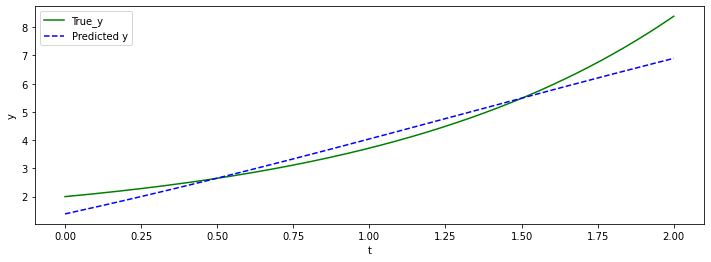

1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,Obtaining library hessian...
Time taken for library-based approach was 25.88s.
Iter 1900 | Total Loss 0.316953


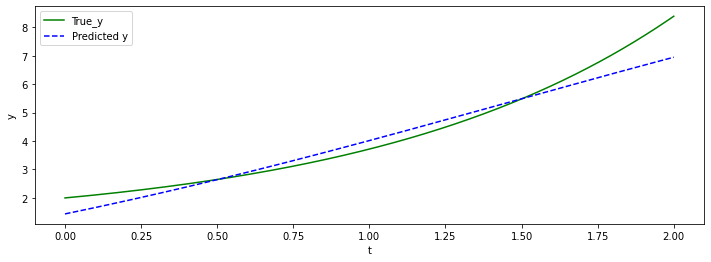

1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,Obtaining library hessian...
Time taken for library-based approach was 25.66s.
Iter 2000 | Total Loss 0.294401


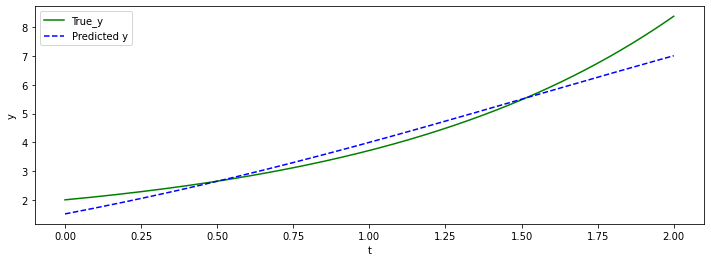

2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,Obtaining library hessian...
Time taken for library-based approach was 24.65s.
Iter 2100 | Total Loss 0.268523


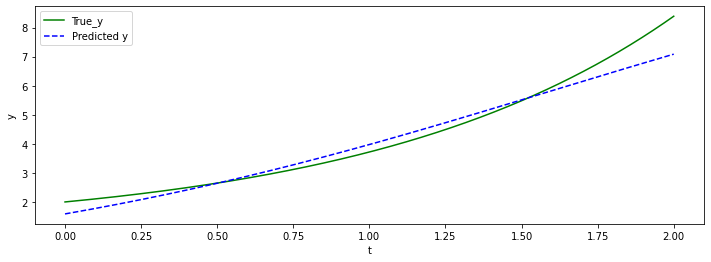

2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199,Obtaining library hessian...
Time taken for library-based approach was 24.43s.
Iter 2200 | Total Loss 0.239732


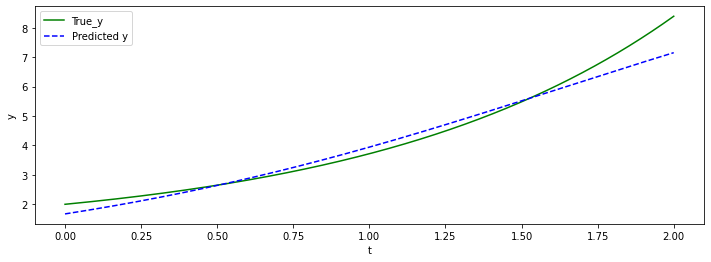

2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,Obtaining library hessian...
Time taken for library-based approach was 24.7s.
Iter 2300 | Total Loss 0.208880


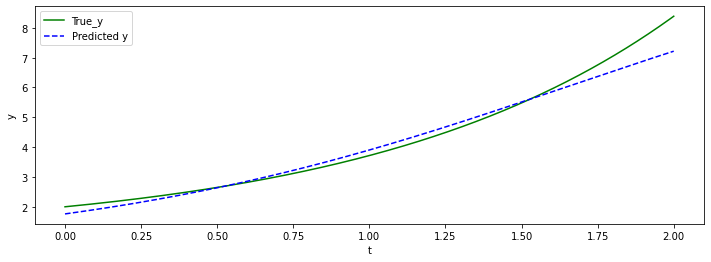

2300,2301,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399,Obtaining library hessian...
Time taken for library-based approach was 26.55s.
Iter 2400 | Total Loss 0.177753


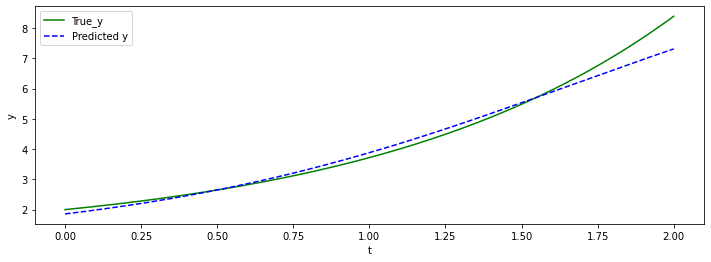

2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435,2436,2437,2438,2439,2440,2441,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,Obtaining library hessian...
Time taken for library-based approach was 26.43s.
Iter 2500 | Total Loss 0.147615


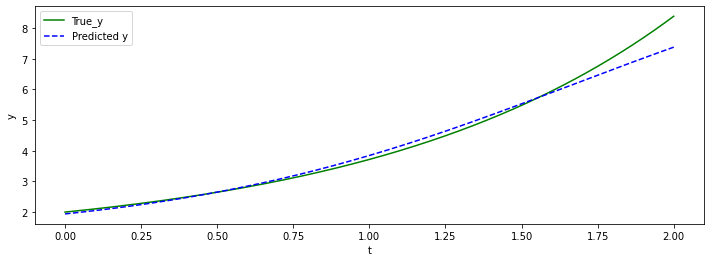

2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,Obtaining library hessian...
Time taken for library-based approach was 25.41s.
Iter 2600 | Total Loss 0.122057


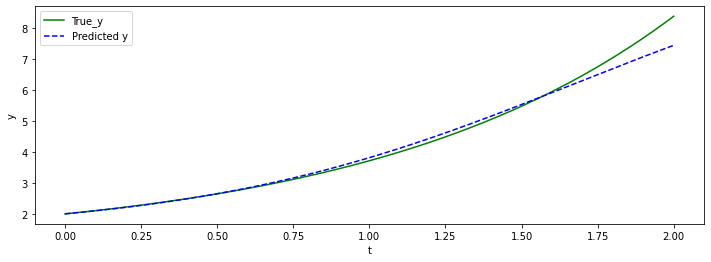

2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699,Obtaining library hessian...
Time taken for library-based approach was 27.2s.
Iter 2700 | Total Loss 0.106179


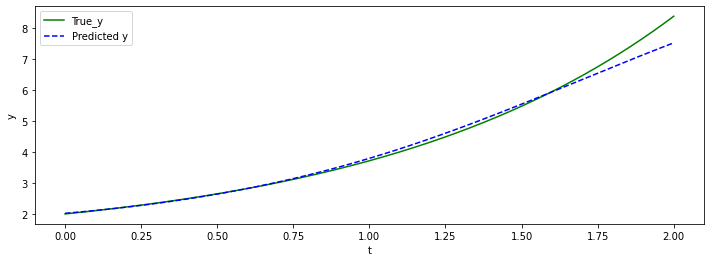

2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,Obtaining library hessian...
Time taken for library-based approach was 27.5s.
Iter 2800 | Total Loss 0.095092


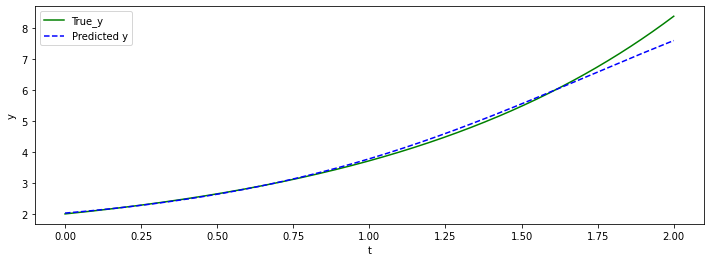

2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,Obtaining library hessian...
Time taken for library-based approach was 26.02s.
Iter 2900 | Total Loss 0.086240


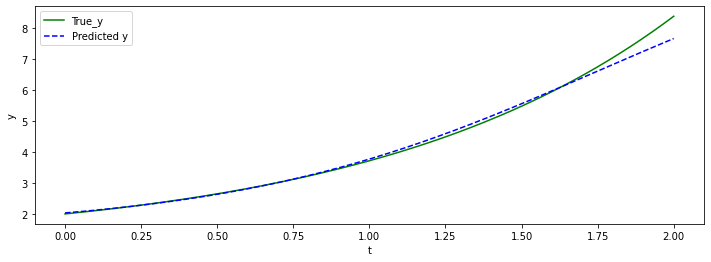

2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,Obtaining library hessian...
Time taken for library-based approach was 25.53s.
Iter 3000 | Total Loss 0.079207


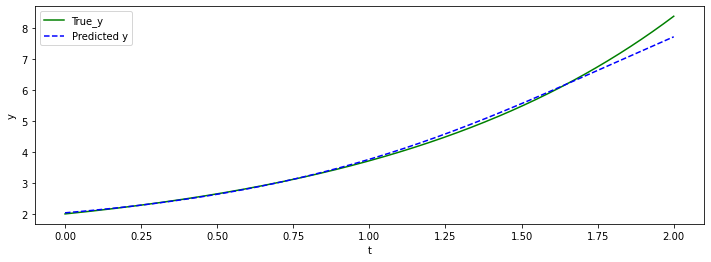

3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,Obtaining library hessian...
Time taken for library-based approach was 25.49s.
Iter 3100 | Total Loss 0.072975


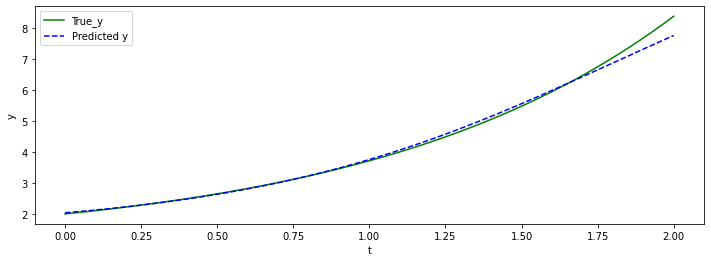

3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135,3136,3137,3138,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199,Obtaining library hessian...
Time taken for library-based approach was 24.57s.
Iter 3200 | Total Loss 0.068300


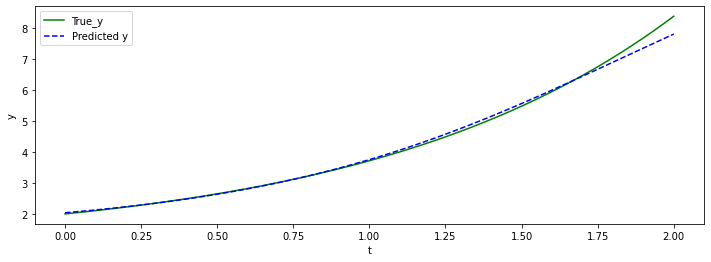

3200,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220,3221,3222,3223,3224,3225,3226,3227,3228,3229,3230,3231,3232,3233,3234,3235,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248,3249,3250,3251,3252,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,Obtaining library hessian...
Time taken for library-based approach was 28.17s.
Iter 3300 | Total Loss 0.063013


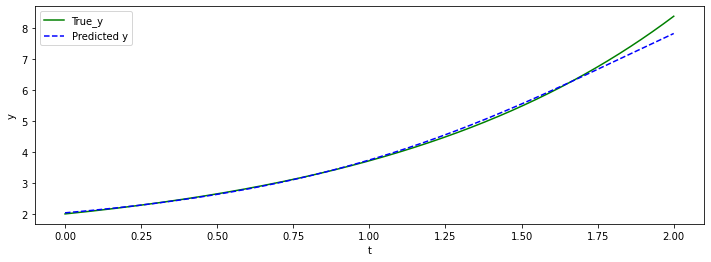

3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3334,3335,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399,Obtaining library hessian...
Time taken for library-based approach was 26.39s.
Iter 3400 | Total Loss 0.059018


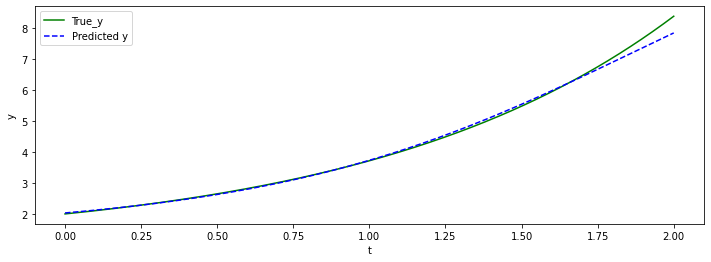

3400,3401,3402,3403,3404,3405,3406,3407,3408,3409,3410,3411,3412,3413,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3424,3425,3426,3427,3428,3429,3430,3431,3432,3433,3434,3435,3436,3437,3438,3439,3440,3441,3442,3443,3444,3445,3446,3447,3448,3449,3450,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,Obtaining library hessian...
Time taken for library-based approach was 26.76s.
Iter 3500 | Total Loss 0.074208


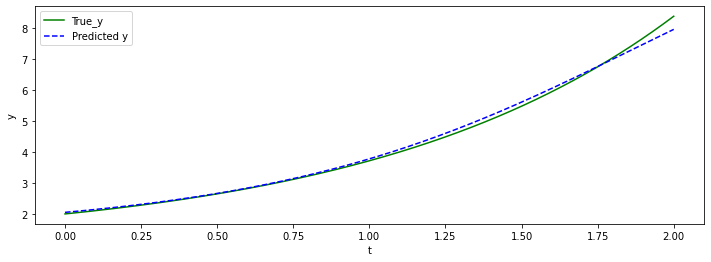

3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516,3517,3518,3519,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559,3560,3561,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599,Obtaining library hessian...
Time taken for library-based approach was 26.09s.
Iter 3600 | Total Loss 0.052733


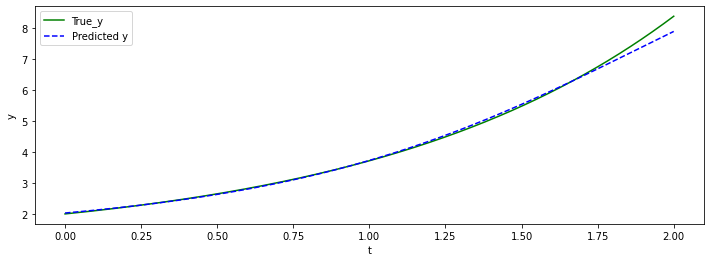

3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658,3659,3660,3661,3662,3663,3664,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3682,3683,3684,3685,3686,3687,3688,3689,3690,3691,3692,3693,3694,3695,3696,3697,3698,3699,Obtaining library hessian...
Time taken for library-based approach was 26.01s.
Iter 3700 | Total Loss 0.050122


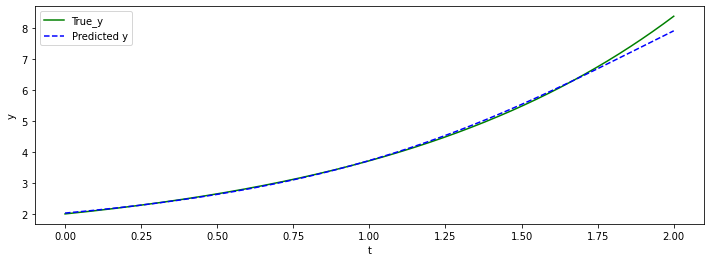

3700,3701,3702,3703,3704,3705,3706,3707,3708,3709,3710,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,3784,3785,3786,3787,3788,3789,3790,3791,3792,3793,3794,3795,3796,3797,3798,3799,Obtaining library hessian...
Time taken for library-based approach was 26.58s.
Iter 3800 | Total Loss 0.047722


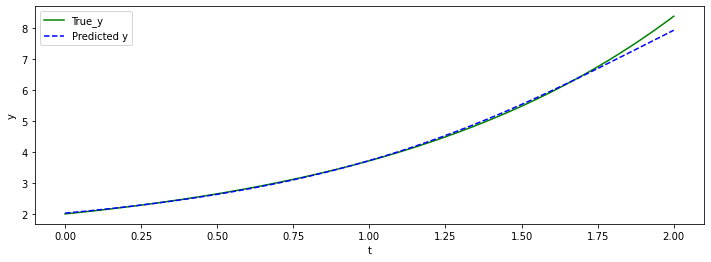

3800,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899,Obtaining library hessian...
Time taken for library-based approach was 25.87s.
Iter 3900 | Total Loss 0.045594


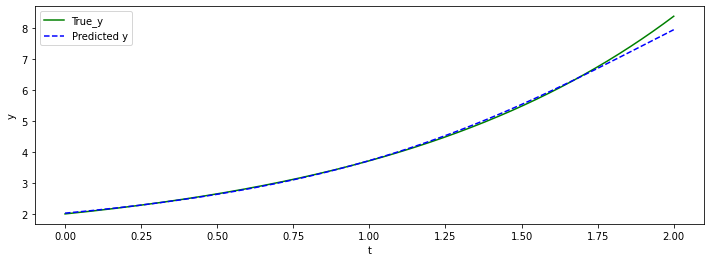

3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952,3953,3954,3955,3956,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999,Obtaining library hessian...
Time taken for library-based approach was 26.4s.
Iter 4000 | Total Loss 0.043640


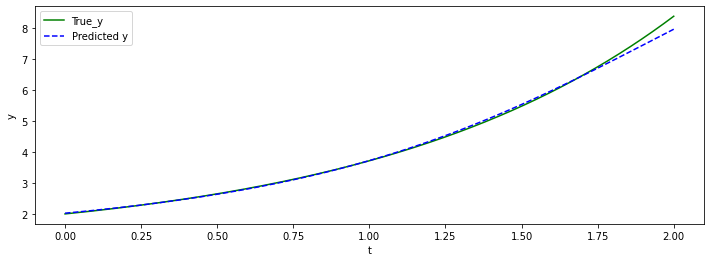

4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043,4044,4045,4046,4047,4048,4049,4050,4051,4052,4053,4054,4055,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097,4098,4099,Obtaining library hessian...
Time taken for library-based approach was 25.79s.
Iter 4100 | Total Loss 0.045540


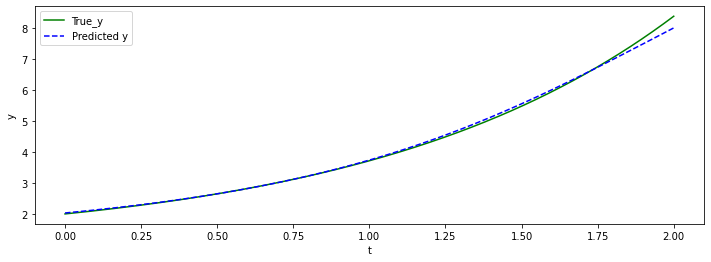

4100,4101,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,4113,4114,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124,4125,4126,4127,4128,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138,4139,4140,4141,4142,4143,4144,4145,4146,4147,4148,4149,4150,4151,4152,4153,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181,4182,4183,4184,4185,4186,4187,4188,4189,4190,4191,4192,4193,4194,4195,4196,4197,4198,4199,Obtaining library hessian...
Time taken for library-based approach was 25.8s.
Iter 4200 | Total Loss 0.040261


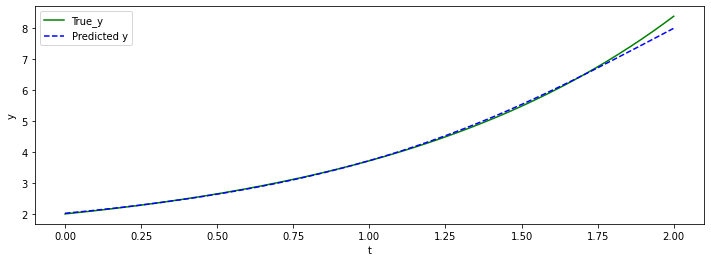

4200,4201,4202,4203,4204,4205,4206,4207,4208,4209,4210,4211,4212,4213,4214,4215,4216,4217,4218,4219,4220,4221,4222,4223,4224,4225,4226,4227,4228,4229,4230,4231,4232,4233,4234,4235,4236,4237,4238,4239,4240,4241,4242,4243,4244,4245,4246,4247,4248,4249,4250,4251,4252,4253,4254,4255,4256,4257,4258,4259,4260,4261,4262,4263,4264,4265,4266,4267,4268,4269,4270,4271,4272,4273,4274,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297,4298,4299,Obtaining library hessian...
Time taken for library-based approach was 26.52s.
Iter 4300 | Total Loss 0.038678


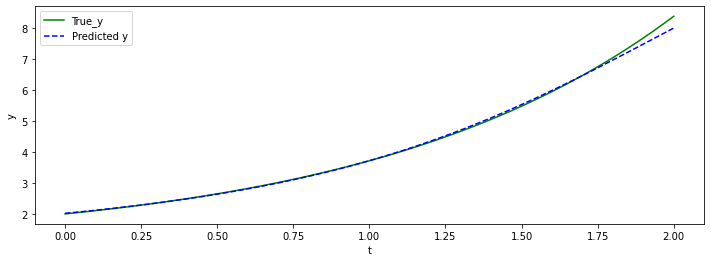

4300,4301,4302,4303,4304,4305,4306,4307,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4375,4376,4377,4378,4379,4380,4381,4382,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,Obtaining library hessian...
Time taken for library-based approach was 27.03s.
Iter 4400 | Total Loss 0.037214


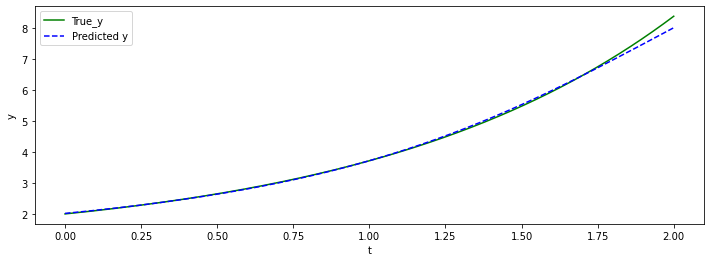

4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426,4427,4428,4429,4430,4431,4432,4433,4434,4435,4436,4437,4438,4439,4440,4441,4442,4443,4444,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4459,4460,4461,4462,4463,4464,4465,4466,4467,4468,4469,4470,4471,4472,4473,4474,4475,4476,4477,4478,4479,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,Obtaining library hessian...
Time taken for library-based approach was 25.96s.
Iter 4500 | Total Loss 0.049215


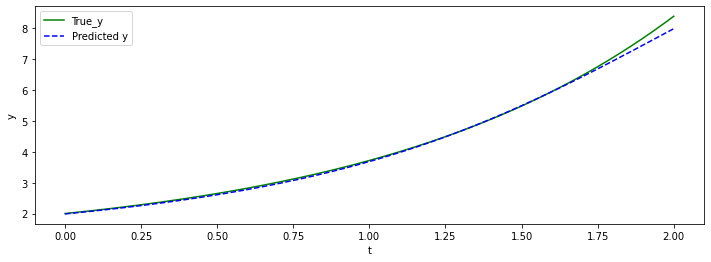

4500,4501,4502,4503,4504,4505,4506,4507,4508,4509,4510,4511,4512,4513,4514,4515,4516,4517,4518,4519,4520,4521,4522,4523,4524,4525,4526,4527,4528,4529,4530,4531,4532,4533,4534,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544,4545,4546,4547,4548,4549,4550,4551,4552,4553,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593,4594,4595,4596,4597,4598,4599,Obtaining library hessian...
Time taken for library-based approach was 28.74s.
Iter 4600 | Total Loss 0.034792


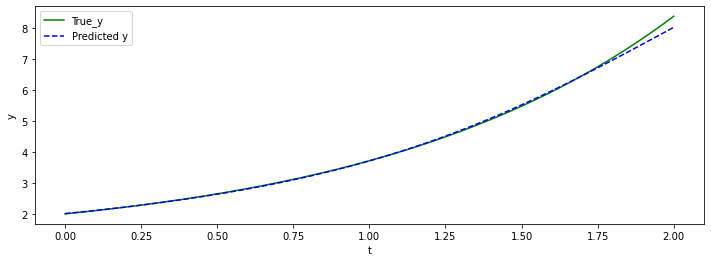

4600,4601,4602,4603,4604,4605,4606,4607,4608,4609,4610,4611,4612,4613,4614,4615,4616,4617,4618,4619,4620,4621,4622,4623,4624,4625,4626,4627,4628,4629,4630,4631,4632,4633,4634,4635,4636,4637,4638,4639,4640,4641,4642,4643,4644,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682,4683,4684,4685,4686,4687,4688,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699,Obtaining library hessian...
Time taken for library-based approach was 27.22s.
Iter 4700 | Total Loss 0.033567


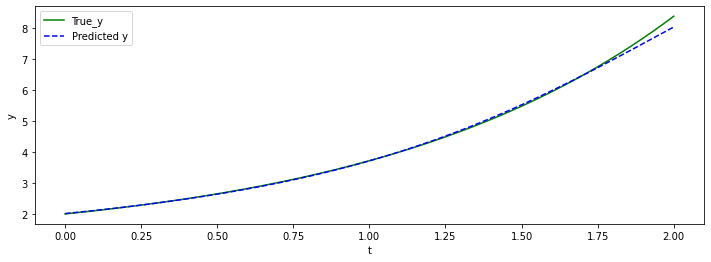

4700,4701,4702,4703,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722,4723,4724,4725,4726,4727,4728,4729,4730,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4742,4743,4744,4745,4746,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756,4757,4758,4759,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,Obtaining library hessian...
Time taken for library-based approach was 27.33s.
Iter 4800 | Total Loss 0.032557


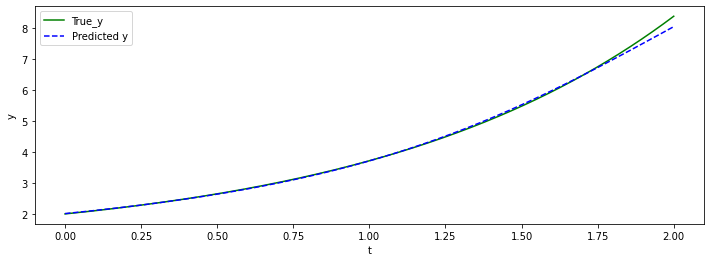

4800,4801,4802,4803,4804,4805,4806,4807,4808,4809,4810,4811,4812,4813,4814,4815,4816,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4828,4829,4830,4831,4832,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4846,4847,4848,4849,4850,4851,4852,4853,4854,4855,4856,4857,4858,4859,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4871,4872,4873,4874,4875,4876,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4889,4890,4891,4892,4893,4894,4895,4896,4897,4898,4899,Obtaining library hessian...
Time taken for library-based approach was 26.48s.
Iter 4900 | Total Loss 0.033070


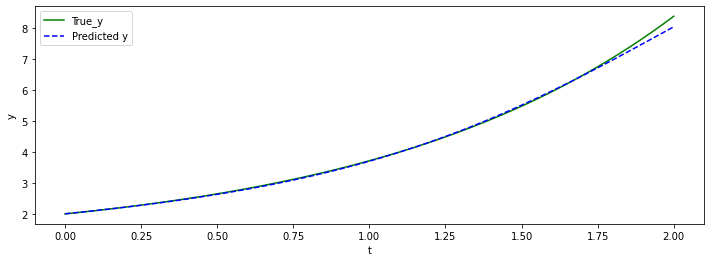

4900,4901,4902,4903,4904,4905,4906,4907,4908,4909,4910,4911,4912,4913,4914,4915,4916,4917,4918,4919,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940,4941,4942,4943,4944,4945,4946,4947,4948,4949,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,Obtaining library hessian...
Time taken for library-based approach was 26.55s.
Iter 5000 | Total Loss 0.040026


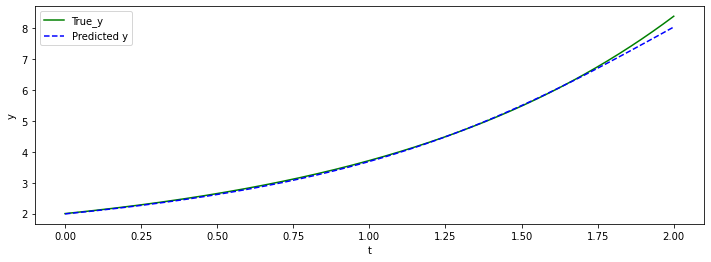

5000,

In [ ]:
if __name__ == '__main__':
    """
    Executes the programme. This includes doing the following:

      - Trains the network;
      - Outputs the results in a series of png files (if desired);
      - Outputs hessian matrix information in list form.
    """

    ii = 0

    net = Ordinary_Net().to(device)
    
    optimizer = optim.RMSprop(net.parameters(), lr=1e-3) #net.parameters are the parameters to optimise.

    #Lists in which to store hessian data.
    #These will be lists of tuples like (iteration number, time, loss, hessian data).
    manual_hessian_data = []
    library_hessian_data = []
    loss_data = []

    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()                                 
        #batch_y0, batch_t, batch_y, t_list = get_batch()             
        pred_y = get_pred_y(t, net)
        loss = torch.mean(torch.abs(pred_y - true_y))        
        loss.backward(create_graph=True)                                                                     
        
        if itr % args.hessian_freq == 0 or itr==1:
          if args.library_hessian:
            print('Obtaining library hessian...')
            library_start = time.time()
            library_hessian = get_library_hessian(net)                       #get hessian with library functions   
            library_end = time.time()
            print("Time taken for library-based approach was " + str(round(library_end-library_start,2)) + "s.")
            library_hessian_data.append((itr, library_end-library_start, loss.item(), library_hessian))

          if args.manual_hessian:
            
            print('Obtaining manual hessian...')
            manual_start = time.time()

            pred_y = get_pred_y(t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            grads = torch.autograd.grad(loss, net.parameters(), create_graph=True)
            parameters = optimizer.param_groups[0]['params']
          
            manual_hessian = get_manual_hessian(grads, parameters)           #get hessian with manual approach.
            manual_end = time.time()
            print("Time taken for manual approach was " + str(round(manual_end-manual_start,2)) + "s.")
            manual_hessian_data.append((itr, manual_end-manual_start, loss.item(), manual_hessian))

          else:
            pass
      

        if itr % args.test_freq == 0:
          ii += 1       
          with torch.no_grad():
              pred_y = get_pred_y(t, net)
              loss = torch.mean(torch.abs(pred_y - true_y))
              loss_data.append((itr, loss.item()))
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y, net, ii)
       
        """
        else:
          if itr % 50 == 0 or itr==1:
            if args.library_hessian:
              print('Obtaining library hessian...')
              library_start = time.time()
              library_hessian = get_library_hessian(func)                       #get hessian with library functions   
              library_end = time.time()
              print("Time taken for library-based approach was " + str(round(library_end-library_start,2)) + "s.")
              library_hessian_data.append((itr, library_end-library_start, loss.item(), library_hessian))
        
          if itr % 50 == 0:
            ii += 1       
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                loss_data.append((itr, loss.item()))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
        """  
        optimizer.step()
        print(itr, end=',')

In [ ]:
#torch.save(net, '/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_normal_nets/exponential_curve/test_3/test_3_model.pt')

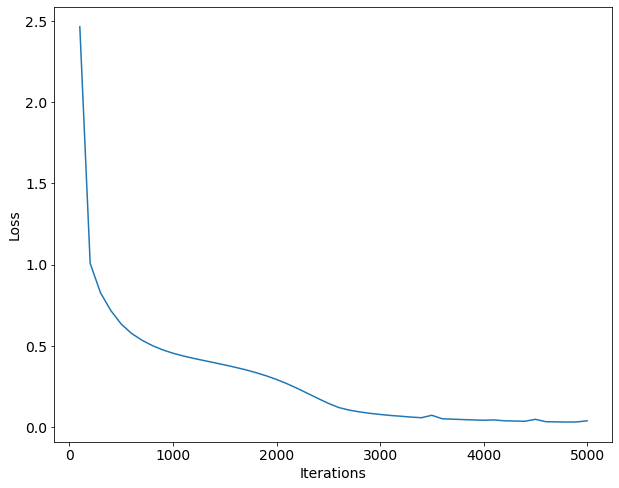

In [ ]:
itrs = []
data = []

for item in loss_data:
  itrs.append(item[0])
  data.append(item[1])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, data)
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_normal_nets/exponential_curve/test_3' 
            #+ '/loss_curve.png')
plt.show()

In [ ]:
for item in library_hessian_data:
  e, v = torch.symeig(item[3])
  plt.hist(e.cpu().numpy(), bins=150)
  plt.title("Iteration: " + str(item[0]))
  plt.xlabel('Eigenvalue')
  plt.ylabel('Density')
  #plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_normal_nets/exponential_curve/test_3' 
              #+ '/eigenvalue_density_plots/eigenvalue_density_' + str(item[0]) + '.png')
  plt.show()

In [ ]:
itrs = []
values = []
for item in library_hessian_data:
  itrs.append(item[0])
  e, v = torch.symeig(item[3])
  value = max(e, key=abs)
  values.append(value)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, values)
plt.title('Extremal Eigenvalues for Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('Extremal Eigenvalue')
#plt.savefig('/content/drive/MyDrive/colab_notebooks/calculating_hessians/testing_on_normal_nets/exponential_curve/test_3' 
            #+ '/extremal_eigenvalues.png')
plt.show()